In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

## Short-time Fourier transform

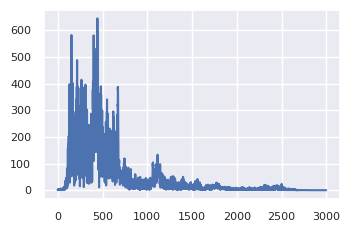

In [2]:
from scipy.fft import fft, ifft, fftfreq

signal = traces["clean_trace"][6]
signal = signal[~np.isnan(signal)]

N, T = len(signal), 1.0/SAMPLING_RATE

spectrum = np.abs(fft(signal)[:N//2])
freqs = fftfreq(N, T)[:N//2]

plt.plot(freqs, spectrum)

Audio split in 50 windows
Each window is 48.50 millisec long
Max frequency is 3.0 kHz


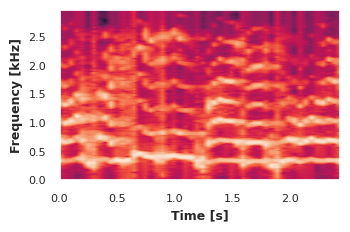

In [3]:
track_index = 1500
signal = traces["clean_trace"][track_index]
signal = signal[~np.isnan(signal)]

M, N, T = 50, len(signal), 1.0/SAMPLING_RATE

windows = np.array_split(signal, M)
winlen = np.min([len(w) for w in windows])

print(f"Audio split in {len(windows)} windows")
print(f"Each window is {winlen/SAMPLING_RATE*1e3:.2f} millisec long")
print(f"Max frequency is {np.max(freqs)*1e-3:.1f} kHz")

STFT = np.zeros((winlen//2, M))

for i, part in enumerate(windows):
    regularized_window = np.hamming(len(part))*part
    window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
    STFT[:winlen//2, i] = np.log(window_spectrum/np.sum(window_spectrum))
    
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]*1e-3

TT, FF = np.meshgrid(TT, FF)    
plt.contourf(TT.T, FF.T, STFT.T, levels=100)

plt.grid(ls="")
# plt.axis("off")
plt.xlabel("Time [s]");
plt.ylabel("Frequency [kHz]");
# plt.title(f"{df.sex[track_index]} {df.vocal_channel[track_index]} STFT");

## Spectral statistics timeseries

Since the stft returns a matrix (bad), It is possible to extract a statictical feature from the spectrum of each window, such as the spectral centroid

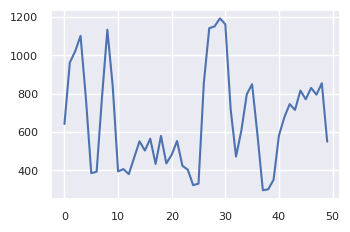

In [4]:
stft_centroid = np.zeros(M)
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]

for i in range(M):
    # get a distribution from STFT
    energy_density = np.exp(STFT[:, i]) - np.min(np.exp(STFT[:, i])) # offsets the minimum to be zero
    energy_density /= np.sum(energy_density)         # normalizes
#     plt.plot(FF, energy_density)

    # gets weighted mean
    stft_centroid[i] = np.sum(FF*energy_density)
    
plt.plot(stft_centroid)

## For the full dataset

Since the tracks have different length, the fourier coefficients have different length.
What is possible to do is to bin the spectrum in a range of freqs and then sum the squares (mean energy).

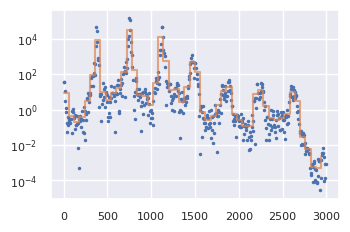

In [5]:
def bin_spectral_energy(spectrum_energy, n_bins, max_freq, sampling_rate=SAMPLING_RATE, plot_check=False):
    T = 1.0/sampling_rate
    
    # Removes higher-pitch part that makes bins unequal
    ss = spectrum_energy[:len(spectrum_energy) - (len(spectrum_energy)%n_bins) ]
    ffs = fftfreq(2*len(ss), T)[:len(ss)]

    ff_bin_edges = np.linspace(0, max_freq, n_bins + 1, endpoint=True)
    
    binned_energies = np.zeros(n_bins)
    for i in range(n_bins):
        binned_energies[i] = np.mean(ss[(ffs >= ff_bin_edges[i])&(ffs < ff_bin_edges[i+1])] )
    
    if plot_check:
        plt.plot(ffs, ss, ls="", marker=".", ms=3)
        plt.step(ff_bin_edges[:-1],binned_energies, where="post",alpha=0.7)
        plt.yscale("log")
    return binned_energies

part = np.array_split(traces["clean_trace"][50], 30)[0]
regularized_window = np.hamming(len(part))*part
window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2

# Saves the binned STFT
u = np.log(bin_spectral_energy(window_spectrum, 50, 3000, plot_check=True))


In [6]:
traces["spectral_centroid"] = []
traces["spectral_mode"] = []
traces["full_stft"] = []

N_SPECTRAL_BINS = 60 
N_TIME_BINS = 30

max_frequencies_taken = np.zeros(len(df))
max_frequencies = max_frequencies_taken.copy()
len_of_windows = max_frequencies.copy()

for tr_indx, tr in tqdm(enumerate(traces["clean_trace"]), total=len(df)):
    
    # Removes padding
    signal = tr[~np.isnan(tr)]
    
    # Gets values of stuff
    N, T = len(signal), 1.0/SAMPLING_RATE

    windows = np.array_split(signal, N_TIME_BINS)
    winlen = np.min([len(w) for w in windows])
    
#     print("signal", len(signal))
#     print("winlen", winlen)
#     print("n of freqs", winlen//2)
    
    STFT = np.zeros((N_TIME_BINS, N_SPECTRAL_BINS))
    STFT_CENTROID = np.zeros(N_TIME_BINS)
    STFT_MODE = np.zeros(N_TIME_BINS)
    FF = fftfreq(winlen, T)[:winlen//2]

    for i, part in enumerate(windows):
        regularized_window = np.hamming(len(part))*part
        window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
        
        # Saves the binned STFT
        STFT[i, :] = np.log(bin_spectral_energy(window_spectrum, N_SPECTRAL_BINS, 3000))
        
        # Gets distribution
        energy_density = window_spectrum /np.sum(window_spectrum)
        
        # Gets weighted mean
        STFT_CENTROID[i] = np.sum(energy_density*FF)
        
        # Gets argmax (i.e. the mode)
        STFT_MODE[i] = FF[np.argmax(energy_density)]

    traces["spectral_centroid"].append(STFT_CENTROID)
    traces["spectral_mode"].append(STFT_MODE)
    traces["full_stft"].append(STFT)
    
    # Saves max freqs taken
    max_frequencies[tr_indx] = (FF[-1])
    max_frequencies_taken[tr_indx] = (FF[N_SPECTRAL_BINS])
    len_of_windows[tr_indx] = winlen
    
# Makes them array
traces["spectral_centroid"] = np.array(traces["spectral_centroid"])
traces["spectral_mode"] = np.array(traces["spectral_mode"])
traces["full_stft"] = np.array(traces["full_stft"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [02:03<00:00, 19.82it/s]


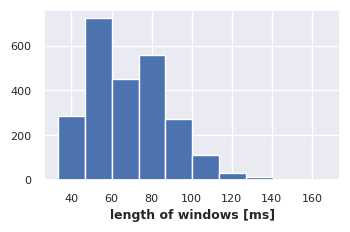

In [7]:
plt.hist(len_of_windows/SAMPLING_RATE*1e3);
plt.xlabel("length of windows [ms]");

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


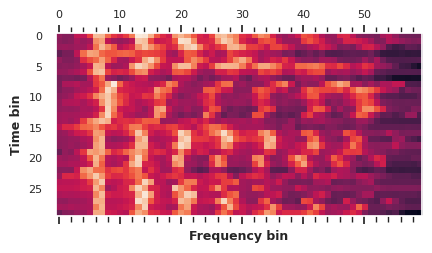

In [8]:
one_curve = traces["full_stft"][1500]
plt.matshow(one_curve)
plt.grid(ls="")
plt.ylabel("Time bin")
plt.xlabel("Frequency bin");

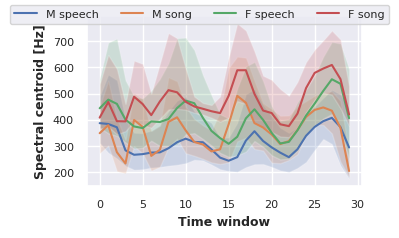

In [9]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = traces["spectral_centroid"][(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="upper center")
plt.ylabel("Spectral centroid [Hz]")
plt.xlabel("Time window");
fig.tight_layout()

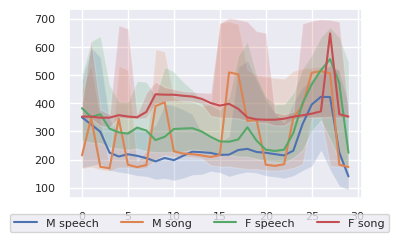

In [10]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = traces["spectral_mode"][(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

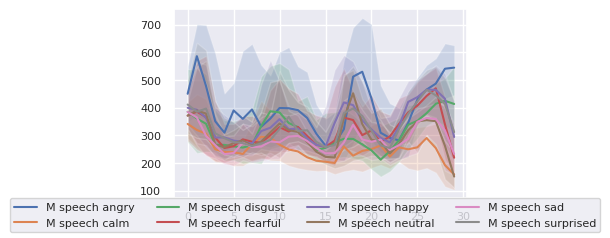

In [11]:
fig, ax = plt.subplots()
for s in ["M"]:
    for vc in ["speech"]:
        for emo in np.unique(df[(df.sex==s)&(df.vocal_channel == vc)].emotion):
        
            subsamp = traces["spectral_centroid"][(df.vocal_channel == vc)&(df.sex==s)&(df.emotion==emo)]
            low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)

            plt.plot(mid, label=f"{s} {vc} {emo}")
            plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

In [12]:
for t in ["spectral_centroid", "spectral_mode", "full_stft"]:
    np.save(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), traces[t])

## Check umap on spectral centroids

In [13]:
from umap import UMAP

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

In [14]:
X = traces["spectral_centroid"]

reducer = UMAP(n_neighbors=10)
embedding = reducer.fit_transform(X)

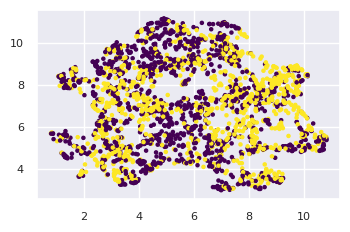

In [15]:
plt.scatter(*embedding.T, s=5, c=(df.emotion=="calm")|(df.emotion=="sad")|(df.emotion=="fearful"), cmap="viridis")

## Test to see the evolution in fourier space

In [16]:
reducer = UMAP(n_neighbors=5)
embedding= reducer.fit_transform(one_curve)

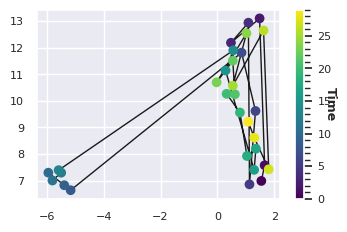

In [17]:
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2, cmap="viridis")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time', rotation=270);

In [18]:
print("full_stft shape",  traces["full_stft"].shape)
X = traces["full_stft"]

# Merges all tracks together
# In this way UMAP learns the manifold of spectral vectors
# independently from the track
X = X.reshape(-1,N_SPECTRAL_BINS)

print(X.shape)

full_stft shape (2452, 30, 60)
(73560, 60)


In [19]:
reducer = UMAP(n_neighbors=10)

N_SUBSAMP = 10_000
shuffled_subsamp = np.arange(len(X))
np.random.shuffle(shuffled_subsamp)
shuffled_subsamp = shuffled_subsamp[:N_SUBSAMP]

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

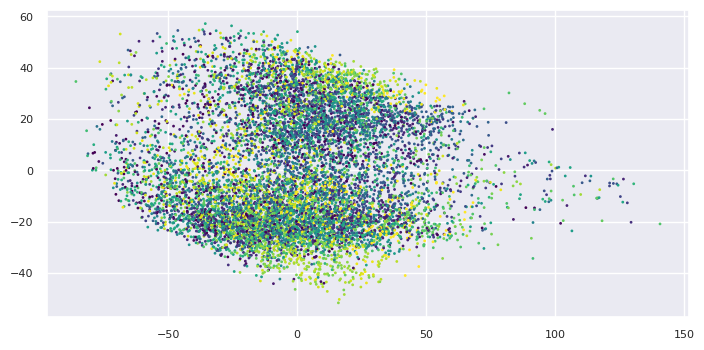

In [33]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
# colors = np.repeat(df.statement == "kids", N_TIME_BINS).values[shuffled_subsamp]
colors = np.tile(range(N_TIME_BINS), len(df))[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=1, c= colors, cmap="viridis")

In [21]:
from sklearn.manifold import Isomap
reducer = Isomap(n_neighbors=10)

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

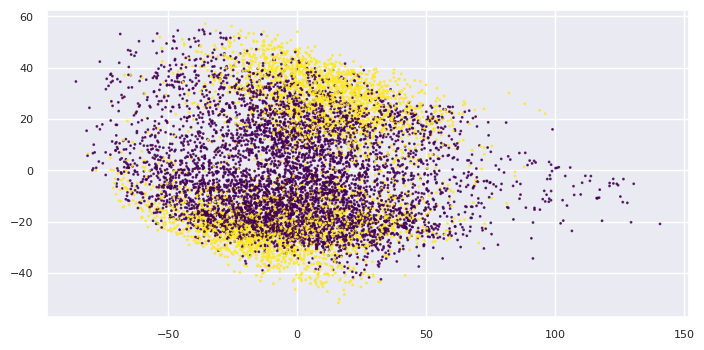

In [22]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
colors = np.repeat(df.vocal_channel == "song", N_TIME_BINS).values[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.8, c= colors, cmap="viridis")

In [25]:
# Now returns to treat each track as a timeseries of points in spectral space
X = X.reshape(-1, N_TIME_BINS, N_SPECTRAL_BINS)

# Predicts the path in 2D that corresponds to a trace
embedding = reducer.transform(X[1500])

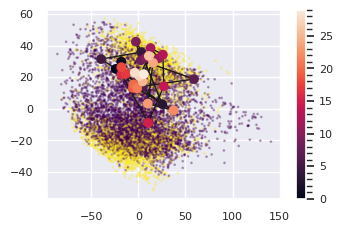

In [28]:
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")

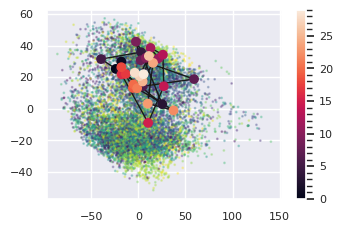

In [30]:
colors = np.tile(range(N_TIME_BINS), len(df))[shuffled_subsamp]
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")